## Import necessary packages

In [49]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import multiprocessing
from functools import partial
from collections import defaultdict
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
sns.set(style="darkgrid")

## Helper functions

#### Preprocessing

In [2]:
def transform_df(df):
        
    switcher = {"radiant":"dire", "dire":"radiant", 0:1, 1:0}
    print('TRANSFORMING ...')
    newdf = pd.DataFrame()
    newcols = defaultdict(list)
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        newcols[f'match_duration_minutes'].append(row['match_duration_minutes'])
        for side in ['radiant', 'dire']:
            newcols[f'{side}_kills'].append(row[f'{side}_kills'])
        for playernum in range(1,6):
            for side in ['radiant', 'dire']:
                for stat in ['hero_id', 'kills', 'deaths', 'assists','networth']:
                    posnum = row[f'{side}_player_{playernum}_position']
                    newcols[f'{side}_pos_{posnum}_{stat}'].append(row[f'{side}_player_{playernum}_{stat}'])
        newcols[f'radiant_win'].append(row['radiant_win'])
        
        newcols[f'match_duration_minutes'].append(row['match_duration_minutes'])
        for side in ['radiant', 'dire']:
            newcols[f'{side}_kills'].append(row[f'{switcher[side]}_kills'])
            
        for playernum in range(1,6):
            for side in ['radiant', 'dire']:
                for stat in ['hero_id', 'kills', 'deaths', 'assists','networth']:
                    posnum = row[f'{side}_player_{playernum}_position']
                    newcols[f'{side}_pos_{posnum}_{stat}'].append(row[f'{switcher[side]}_player_{playernum}_{stat}'])
        newcols['radiant_win'].append(switcher[row['radiant_win']])
        
    keys = list(newcols.keys())
    radkeys = [key for key in keys if 'radiant_pos' in key]
    radkeys.sort(key=lambda x: int(x.split('_')[2]))
    dirkeys = [key for key in keys if 'dire_pos' in key]
    dirkeys.sort(key=lambda x: int(x.split('_')[2]))
    
    for key in ['match_duration_minutes', 'radiant_kills', 'dire_kills']:
        newdf[key]=newcols[key]
    for key in radkeys:
        newdf[key]=newcols[key]
    for key in dirkeys:
        newdf[key]=newcols[key]
    newdf['radiant_win']=newcols['radiant_win']
    print('DONE.')
    return newdf


def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()  
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

def get_corr_desc(df, feature):
    corr = df.corr()
    return corr['dire_pos_4_assists'].sort_values(ascending=False)


def get_gain(X_train, y_train):
    mutual_info = mutual_info_classif(X_train, y_train)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X_train.columns
    return mutual_info

def get_gain_desc(mutual_info):
    return mutual_info.sort_values(ascending=False)

def plot_gain_desc(mutual_info):
    mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,8))
    
def select_k_best(X_train, y_train, X_test, k=25):
    sel_5_feats = SelectKBest(mutual_info_classif, k=k)
    sel_5_feats.fit(X_train, y_train)
    selected_cols = X_train.columns[sel_5_feats.get_support()]
    return X_train[selected_cols], X_test[selected_cols], selected_cols


def decompose(X_train_scaled, X_test_scaled, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    return X_train_pca, X_test_pca

def correlation_test(dataset, threshold):
    features_for_drop = correlation(dataset, threshold)
    if not features_for_drop:
        print(f'No features will be dropped')
    else:
        print(f'{features_for_drop=}')
    return dataset.drop(columns=list(features_for_drop))

def get_features_with_most_missing_values(dataframe):
    missing_values_count = dataframe.isna().sum()
    features_with_most_missing_values = missing_values_count.sort_values(ascending=False)
    print(features_with_most_missing_values)

#### Model Training & Validation

In [3]:
def split_data(df):
    continuous_features = ['radiant_kills', 'dire_kills', 'match_duration_minutes']
    for i in range(1, 6):
        for team in ['radiant', 'dire']:
            for suffix in ['kills', 'deaths','assists','networth']:
                col_str = f"{team}_pos_{i}_{suffix}"
                continuous_features.append(col_str)
    X = df.drop(labels=['radiant_win'], axis=1)
    X_cont = X[continuous_features]
    y = df['radiant_win']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
    X_cont_train, X_cont_test, y_train, y_test = train_test_split(X_cont, y, test_size=0.25, random_state=0)
    print(f"{X_train.shape=}, {X_test.shape=}")
    return X_train, X_test, y_train, y_test, X_cont_train, X_cont_test, y_train, y_test

def print_results(model_name, results):
    print(f'BEST PARAMS FOR {model_name}: {results.best_params_}\n')
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
    print()

def get_best_model(model_name, clf, params, cv=5):
    grid = GridSearchCV(clf, params, cv=cv)
    if model_name == 'GaussianNB':
        grid.fit(X_train_pca, y_train)
    else:
        grid.fit(X_train_scaled, y_train)
    print_results(model_name, grid)
    return grid.best_estimator_

def get_scores(models):
    for model_name in models:   
        model = models[model_name]
        if model_name == 'GaussianNB':
            y_pred = model.predict(X_test_pca)
            y_pred_prob = model.predict_proba(X_test_pca)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        else:
            y_pred = model.predict(X_test_scaled)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        roc_auc = auc(fpr, tpr)
        scores = {
            "accuracy":accuracy_score(y_test,y_pred),
            "precision":precision_score(y_test,y_pred),
            "recall":recall_score(y_test, y_pred),
            "f1_score":f1_score(y_test,y_pred),
            "roc_auc_score":roc_auc
        }
        print('-'*10 + f'{model_name}' + '-'*10)
        for score in scores:
            print(f'{score} : {scores[score]}')
            
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

#### Model testing & evaluation

In [4]:
def generate_testcases(df):
    newtest_set = pd.DataFrame()

    for col in df.columns:
        if 'duration' in col or 'win' in col or 'id' in col:
            newtest_set[col] = df[col]    
    for i in range(1,6):
        for side in ['radiant', 'dire']:
            newtest_set[f'{side}_pos_{i}_hero_id'] = newtest_set[f'{side}_pos_{i}_hero_id'].map(id_to_hero)
    return newtest_set
        
def calculate_metrics(results):
    TP, TN, FP, FN = results
    if (TP + TN + FP + FN) == 0 or (TP + FN) == 0 or (TP + FP) == 0:
        return 0, 0, 0, 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    if recall == 0 and precision == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, recall, precision, f1_score

def row_operation(row, model_name):
    
    tp, tn, fp, fn = 0,0,0,0
    
    rad_heroes = []
    dire_heroes = []

    for i in range(1,6):  
        rad_heroes.append(row[f'radiant_pos_{i}_hero_id'])
    for i in range(1,6):  
        dire_heroes.append(row[f'dire_pos_{i}_hero_id'])

    for i in range(6):
        heroes_stats = []
        for j in range(5):
            pos = 'POSITION_{}'.format(j+1)
            arr = df_array[i]
            if((rad_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(rad_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())

            if((dire_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(dire_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())

        datapoint = {'first_blood_time_seconds':240,
                         'radiant_kills' : 0, 
                         'dire_kills': 0,
                         'match_duration_minutes':0,
                        }
        for j in range(5): #j - txt_list
            for k in range(5): #k - order
                if (j == 0):
                    datapoint[txt_list[j].format(side = sides[0], order = orders[k])] = hero_to_id[rad_heroes[k]]
                    datapoint[txt_list[j].format(side = sides[1], order = orders[k])] = hero_to_id[dire_heroes[k]]
                else:
                    datapoint[txt_list[j].format(side = sides[0], order = orders[k])] = heroes_stats[2*k][j - 1]
                    datapoint[txt_list[j].format(side = sides[1], order = orders[k])] = heroes_stats[2*k + 1][j - 1]
        for key,val in datapoint.items():
            datapoint[key]=[val]
        datapoint = pd.DataFrame(datapoint)
        dire_kill_sum = 0
        radiant_kill_sum = 0
        for d in range(1,6):
            colstrr = f'radiant_pos_{d}_kills'
            colstrd = f'dire_pos_{d}_kills'
            radiant_kill_sum += datapoint[colstrr]
            dire_kill_sum += datapoint[colstrd]
            
        datapoint['radiant_kills']=radiant_kill_sum
        datapoint['dire_kills']=dire_kill_sum
        datapoint = datapoint[selected_cols]
        Xs = scaler.fit_transform(X_train_selected)
        datapoint = scaler.transform(datapoint)
        test_model = models[model_name]
        prediction = test_model.predict(datapoint)[0]
        start, end = duration[i][0], duration[i][1]
        
        if end=='infinity':
            end = float('inf')
        if start <= row['match_duration_minutes'] and row['match_duration_minutes'] <= end:
            if row['radiant_win']==1 and prediction==1:
                tp+=1
            if row['radiant_win']==0 and prediction==0:
                tn+=1
            if row['radiant_win']==1 and prediction==0:
                fn+=1
            if row['radiant_win']==0 and prediction==1:
                fp+=1
            break
    return [tp, tn, fp, fn]

def process_chunk(chunk, modelname):
    counts = np.array([0]*4)
    for _, row in tqdm(chunk.iterrows(), total=len(chunk)):
        counts += np.array(row_operation(row, modelname))
    return counts

def predict_outcome_at_different_time(rad_heroes, dire_heroes,model_name='LDA'):
    
    for i in range(6):
        heroes_stats = []
        for j in range(5):
            pos = 'POSITION_{}'.format(j+1)
            arr = df_array[i]
            if((rad_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(rad_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())
                
            if((dire_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(dire_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())
                
        datapoint = {'first_blood_time_seconds':240,
                     'radiant_kills' : 0, 
                     'dire_kills': 0,
                     'match_duration_minutes':0,
                    }
        
        for j in range(5): #j - txt_list
            for k in range(5): #k - order
                if (j == 0):
                    datapoint[txt_list[j].format(side = sides[0], order = orders[k])] = hero_to_id[rad_heroes[k]]
                    datapoint[txt_list[j].format(side = sides[1], order = orders[k])] = hero_to_id[dire_heroes[k]]
                else:
                    datapoint[txt_list[j].format(side = sides[0], order = orders[k])] = heroes_stats[2*k][j - 1]
                    datapoint[txt_list[j].format(side = sides[1], order = orders[k])] = heroes_stats[2*k + 1][j - 1]
    
        for key,val in datapoint.items():
            datapoint[key]=[val]
        datapoint = pd.DataFrame(datapoint)
    
        dire_kill_sum = 0
        radiant_kill_sum = 0
        for d in range(1,6):
            colstrr = f'radiant_pos_{d}_kills'
            colstrd = f'dire_pos_{d}_kills'
            radiant_kill_sum += datapoint[colstrr]
            dire_kill_sum += datapoint[colstrd]
    
        datapoint['radiant_kills']=radiant_kill_sum
        datapoint['dire_kills']=dire_kill_sum
        datapoint = datapoint[selected_cols]
        _ = scaler.fit_transform(X_train_selected)
        datapoint = scaler.transform(datapoint)
        test_model = models[model_name]
        prediction = test_model.predict_proba(datapoint)
    
        rad_win_chance = round(prediction[0][1]*100,2)
        dire_win_chance = round(prediction[0][0]*100,2)
        
        print(f'For interval {duration[i][0]} to {duration[i][1]} minutes:')
        print(f'Radiant Win : {rad_win_chance}%\nDire Win : {dire_win_chance}')

        if rad_win_chance>dire_win_chance:
            print('So, Radiant will most likely win')
        else:
            print('So, Dire will most likely win')
        print('-'*20)
        
def evaluate_model(test, model_name='LDA'):
    num_processes = multiprocessing.cpu_count()
    chunks = np.array_split(test, num_processes)
    pool = multiprocessing.Pool(processes=num_processes)
    _process_chunk = partial(process_chunk, modelname=model_name)
    results = np.array([0]*4)
    with tqdm(total=num_processes) as pbar:
        for result in pool.imap_unordered(_process_chunk, chunks):
            results+=result
            pbar.update()
    pool.close()
    pool.join()
     
    accuracy, recall, precision, f1_score = calculate_metrics(results)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1_score)

#### Ad-hoc helper functions

In [5]:
def get_categorical_cols(df, k):
    cat_cols = []
    for column in df.columns:
        if df[column].dtype == 'string[pyarrow]' and len(df[column].unique()) >= k:
            cat_cols.append(column)
    return cat_cols

def get_cols(df):
    for col in df.columns:
        print(col)

def predict_outcome_dummy(rad_heroes, dire_heroes, model_name='LDA'):
    datapoint = {'first_blood_time_seconds':240,
                 'radiant_kills' : 0, 
                 'dire_kills': 0,
                 'match_duration_minutes':0,
                 'radiant_pos_1_hero_id': hero_to_id['Io'],
                 'radiant_pos_1_kills': 1.45,
                 'radiant_pos_1_deaths': 10.27,
                 'radiant_pos_1_assists': 25.82,
                 'radiant_pos_1_networth': 14948.18,
                 'radiant_pos_2_hero_id': hero_to_id['Riki'],
                 'radiant_pos_2_kills': 2.69,
                 'radiant_pos_2_deaths': 11.85,
                 'radiant_pos_2_assists': 36.62,
                 'radiant_pos_2_networth': 15097.69,
                 'radiant_pos_3_hero_id': hero_to_id['Bane'],
                 'radiant_pos_3_kills': 3.94,
                 'radiant_pos_3_deaths': 14.06,
                 'radiant_pos_3_assists': 25.19,
                 'radiant_pos_3_networth': 15907.75,
                 'radiant_pos_4_hero_id': hero_to_id['Tusk'],
                 'radiant_pos_4_kills': 2.85,
                 'radiant_pos_4_deaths': 15.32,
                 'radiant_pos_4_assists': 24.71,
                 'radiant_pos_4_networth': 16305.97,
                 'radiant_pos_5_hero_id': hero_to_id['Oracle'],
                 'radiant_pos_5_kills': 3.95,
                 'radiant_pos_5_deaths': 9.00,
                 'radiant_pos_5_assists': 23.00,
                 'radiant_pos_5_networth': 16328.42,
                 'dire_pos_1_hero_id': hero_to_id['Arc Warden'],
                 'dire_pos_1_kills': 11.3,
                 'dire_pos_1_deaths': 6.6,
                 'dire_pos_1_assists': 12.3,
                 'dire_pos_1_networth': 50494.9,
                 'dire_pos_2_hero_id': hero_to_id['Medusa'],
                 'dire_pos_2_kills': 9.68,
                 'dire_pos_2_deaths': 4.8,
                 'dire_pos_2_assists': 15.64,
                 'dire_pos_2_networth': 50757.05,
                 'dire_pos_3_hero_id': hero_to_id['Naga Siren'],
                 'dire_pos_3_kills': 7.68,
                 'dire_pos_3_deaths': 4.94,
                 'dire_pos_3_assists': 14.3,
                 'dire_pos_3_networth': 51436.8,
                 'dire_pos_4_hero_id': hero_to_id['Anti-Mage'],
                 'dire_pos_4_kills': 15.47,
                 'dire_pos_4_deaths': 4.84,
                 'dire_pos_4_assists': 14.11,
                 'dire_pos_4_networth': 51788.42,
                 'dire_pos_5_hero_id': hero_to_id["Nature's Prophet"],
                 'dire_pos_5_kills': 14.09,
                 'dire_pos_5_deaths': 6,
                 'dire_pos_5_assists': 16.18,
                 'dire_pos_5_networth': 52334.64,
    }
    
    for key,val in datapoint.items():
        datapoint[key]=[val]
    datapoint = pd.DataFrame(datapoint)
    
    dire_kill_sum = 0
    radiant_kill_sum = 0
    for i in range(1,6):
            colstrr = f'radiant_pos_{i}_kills'
            colstrd = f'dire_pos_{i}_kills'
            radiant_kill_sum += datapoint[colstrr]
            dire_kill_sum += datapoint[colstrd]
    
    datapoint['radiant_kills']=radiant_kill_sum
    datapoint['dire_kills']=dire_kill_sum
    datapoint = datapoint[selected_cols]
    _ = scaler.fit_transform(X_train_selected)
    datapoint = scaler.transform(datapoint)
    test_model = models[model_name]
    prediction = test_model.predict_proba(datapoint)
    
    rad_win_chance = round(prediction[0][1]*100,2)
    dire_win_chance = round(prediction[0][0]*100,2)
    
    print(f'Radiant Win : {rad_win_chance}%\nDire Win : {dire_win_chance}')
    print('-'*20)
    if rad_win_chance>dire_win_chance:
        print('So, Radiant will most likely win')
    else:
        print('So, Dire will most likely win')

In [6]:
# Global Variables
dir_path = '../input/dota-2-matches-pro-leagues/'
matches_path = dir_path + 'dota2_matches.parquet'
versions_path = dir_path + 'dota2_versions.csv'
LOWER_THRESHOLD_DATE = '2023-01-01'

In [7]:
matches = pd.read_parquet(matches_path, engine='pyarrow')

## Missing Values

In [8]:
winner_na = matches.winner_id.isna()
radiant_na = matches.radiant_team_id.isna()
dire_na = matches.dire_team_id.isna()

len_init = len(matches)

matches = matches[~(winner_na | radiant_na | dire_na)].copy()
print(f'Missing values: {(len_init - len(matches)) / len_init * 100:.2f}%')

Missing values: 0.98%


In [9]:
print(f'Missing values of the whole dataframe: {matches.isna().sum().sum()}')
print(f'Fraction of missed values: {matches.isna().sum().sum() / (matches.shape[0] * matches.shape[1])}')
print(f'Fraction of matches that have at least 1 missing value: {(matches.isna().sum(1) > 0).mean()}')

Missing values of the whole dataframe: 2180785
Fraction of missed values: 0.09550612727172399
Fraction of matches that have at least 1 missing value: 0.691219839905264


In [10]:
matches['year_month'] = matches.match_start_date_time.dt.to_period('M')

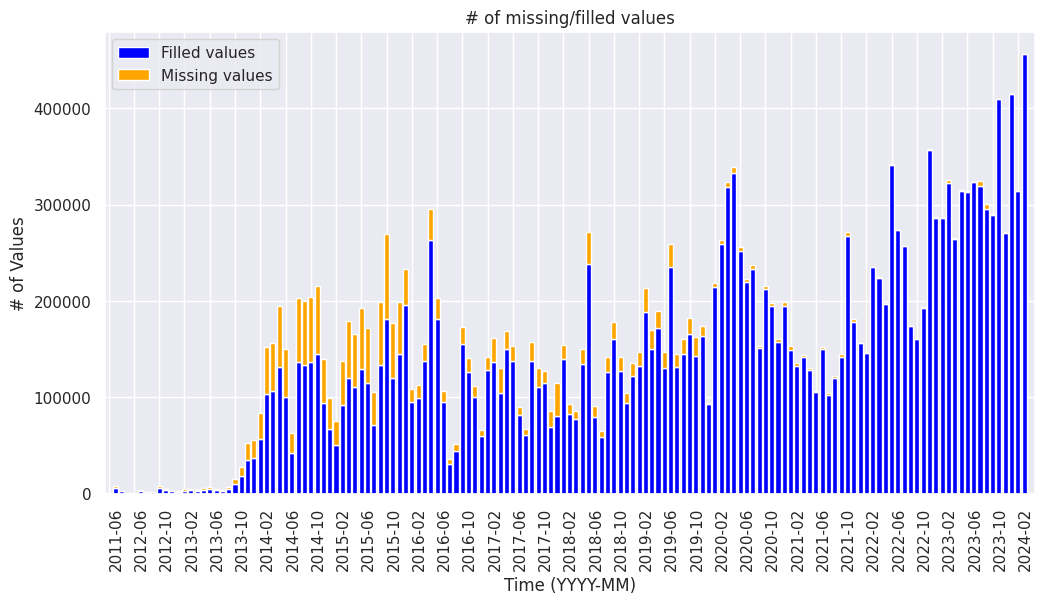

In [11]:
monthly_valid_values = (~matches.isna()).groupby(matches.year_month).sum().sum(1)
monthly_missing_values = matches.isna().groupby(matches['year_month']).sum().sum(1)

plt.figure(figsize=(12, 6))

valid_label = 'Filled values'
missing_label = 'Missing values'
monthly_valid_values.plot(kind='bar', width=0.8, color='blue', label=valid_label)
monthly_missing_values.plot(kind='bar', bottom=monthly_valid_values, width=0.8,
                            color='orange', label=missing_label)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of Values')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()

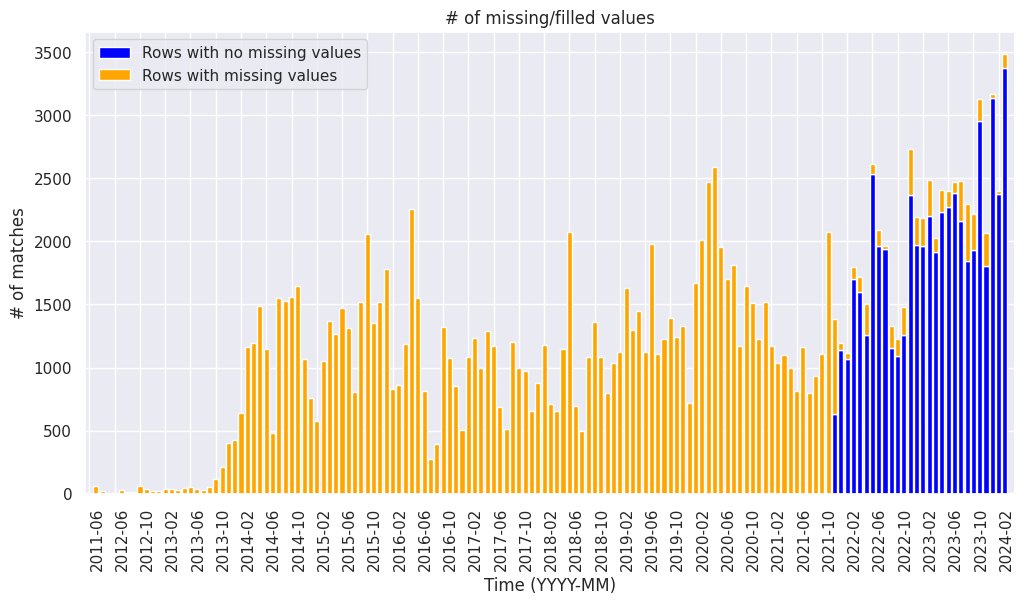

In [12]:
all_rows_per_month = matches.groupby('year_month').size()
corrupted_rows_per_month = matches[matches.isna().sum(1) > 0].groupby('year_month').size()
corrupted_rows_per_month = corrupted_rows_per_month.reindex(all_rows_per_month.index, fill_value=0)
complete_rows_per_month = all_rows_per_month.sub(corrupted_rows_per_month, fill_value=0)

complete_label = 'Rows with no missing values'
corrupted_label = 'Rows with missing values'

plt.figure(figsize=(12, 6))
complete_rows_per_month.plot(kind='bar', width=0.8, color='blue', label=complete_label)
corrupted_rows_per_month.plot(kind='bar', bottom=complete_rows_per_month, width=0.8,
                             color='orange', label=corrupted_label)

plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of matches')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()


In [13]:
print('Features that do not have any missing values:')
matches.columns[matches.isna().sum(0) == 0].tolist()

Features that do not have any missing values:


['league',
 'league_id',
 'league_tier',
 'series_id',
 'series_type',
 'match_id',
 'match_start_date_time',
 'match_duration_seconds',
 'radiant_team_id',
 'dire_team_id',
 'winner_id',
 'radiant_player_1_hero_id',
 'radiant_player_1_kills',
 'radiant_player_1_deaths',
 'radiant_player_1_assists',
 'year_month']

In [14]:
matches.columns[matches[matches.match_start_date_time < '2021-01-01'].isna().mean() == 1]

Index(['radiant_kills', 'dire_kills'], dtype='object')

In [15]:
radiant_kills_feats = [f'radiant_player_{i}_kills' for i in range(1, 6)]
matches['radiant_kills'] = matches[radiant_kills_feats].sum(1)
dire_kills_feats = [f'dire_player_{i}_kills' for i in range(1, 6)]
matches['dire_kills'] = matches[dire_kills_feats].sum(1)
matches['total_kills'] = matches.radiant_kills + matches.dire_kills

## Match duration

In [16]:
matches['match_duration_minutes'] = matches.match_duration_seconds / 60
matches.match_duration_minutes.describe()

count     175646.0
mean      34.43789
std      11.246879
min            0.0
25%      26.783333
50%           33.1
75%          40.85
max         289.45
Name: match_duration_minutes, dtype: double[pyarrow]

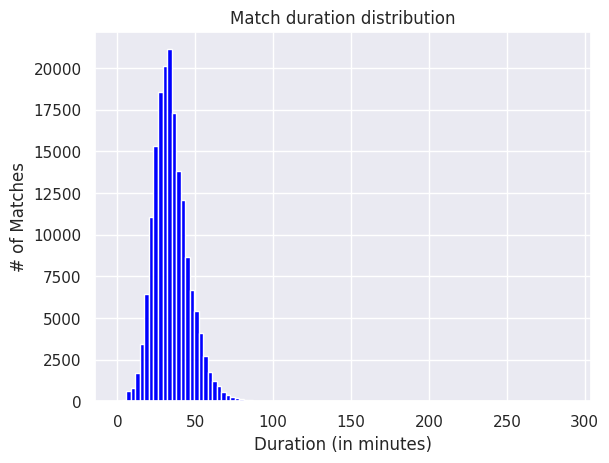

In [17]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

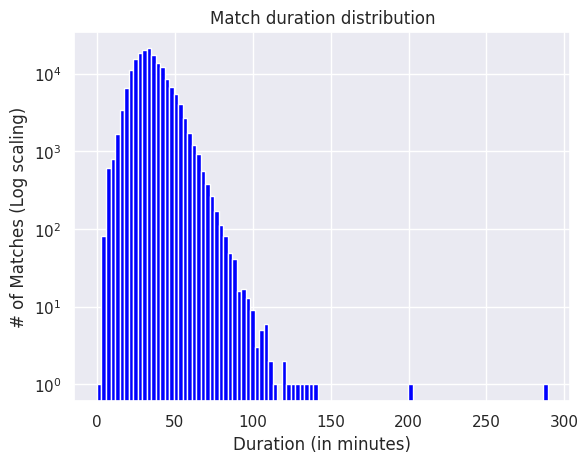

In [18]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches (Log scaling)')
plt.yscale('log')
plt.show()

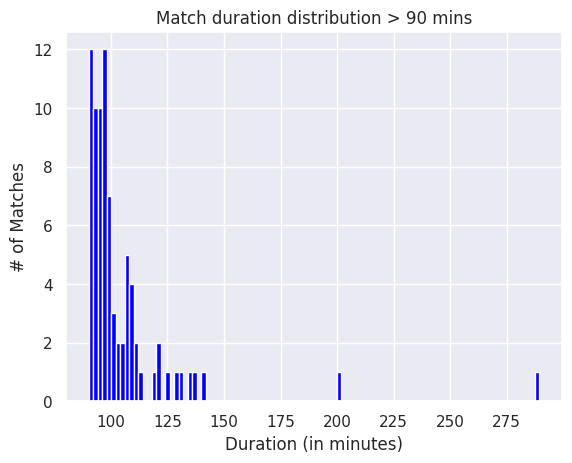

In [19]:
plt.hist(matches[matches.match_duration_minutes >= 90].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution > 90 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

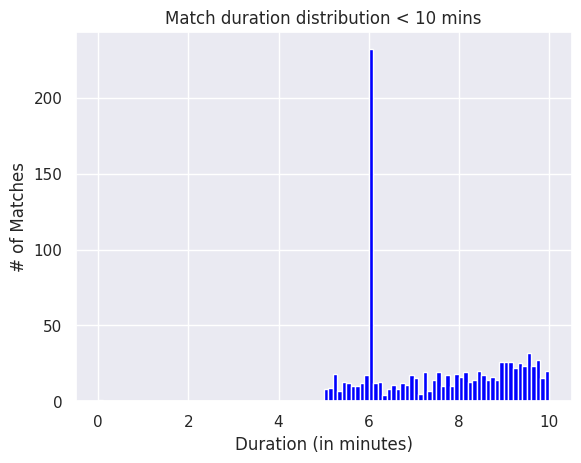

In [20]:
plt.hist(matches[matches.match_duration_minutes <= 10].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution < 10 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

In [21]:
print("Anomaly detected")
print(matches[matches.match_duration_minutes <= 10].match_duration_minutes.value_counts())


Anomaly detected
match_duration_minutes
6.0         212
9.133333     10
8.45          8
9.766667      7
8.166667      7
           ... 
6.066667      1
5.85          1
9.2           1
7.633333      1
9.9           1
Name: count, Length: 269, dtype: int64[pyarrow]


In [22]:
matches['radiant_win'] = (matches.winner_id == matches.radiant_team_id)
matches_6_mins = matches[matches.match_duration_minutes == 6]

print(f'Radiant win rate for 6-min long matches : {round(matches_6_mins.radiant_win.mean()*100,2)} %')
print(f'Radiant win rate for all matches : {round(matches.radiant_win.mean()*100,2)} %')

Radiant win rate for 6-min long matches : 4.72 %
Radiant win rate for all matches : 51.27 %


## Net Worth vs Duration

In [23]:

common_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]


player_dfs = []


for i in range(1, 6):
    for team in ['radiant', 'dire']:

        player_cols = [col for col in matches.columns if col.startswith(f"{team}_player_{i}_")]

        selected_columns = common_features + player_cols

        temp_df = matches[selected_columns].copy()

        temp_df.columns = [col.replace(f"{team}_player_{i}_", '') if col.startswith(f"{team}_player_{i}_") else col for col in temp_df.columns]

        temp_df['team'] = team

        temp_df['position'] = temp_df.position.apply(lambda s: int(s[-1]) if pd.notna(s) and s != '' else pd.NA)
        temp_df['win'] = temp_df.radiant_win if team == 'radiant' else ~temp_df.radiant_win
        temp_df['win'] = temp_df.win.astype(bool)

        player_dfs.append(temp_df)


players = pd.concat(player_dfs, ignore_index=True)


In [24]:
[col for col in
matches.columns[matches[matches.match_start_date_time >= '2020-01-01'].isna().sum(0) == 0]
if col.endswith('networth')
]

['radiant_player_1_networth',
 'radiant_player_2_networth',
 'radiant_player_3_networth',
 'radiant_player_4_networth',
 'radiant_player_5_networth',
 'dire_player_1_networth',
 'dire_player_2_networth',
 'dire_player_3_networth',
 'dire_player_4_networth',
 'dire_player_5_networth']

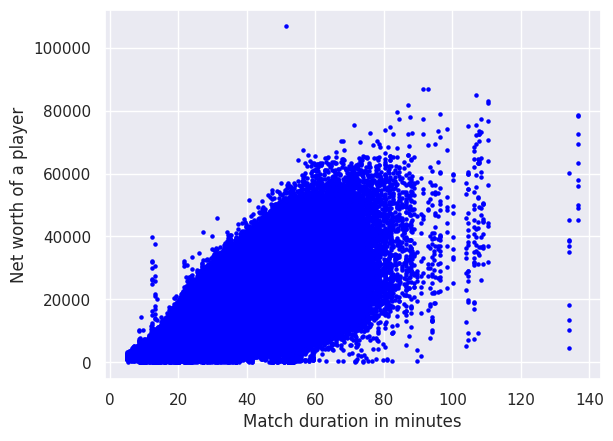

In [25]:
plt.scatter(players.match_duration_minutes, players.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

#### Too dense, we need a subset

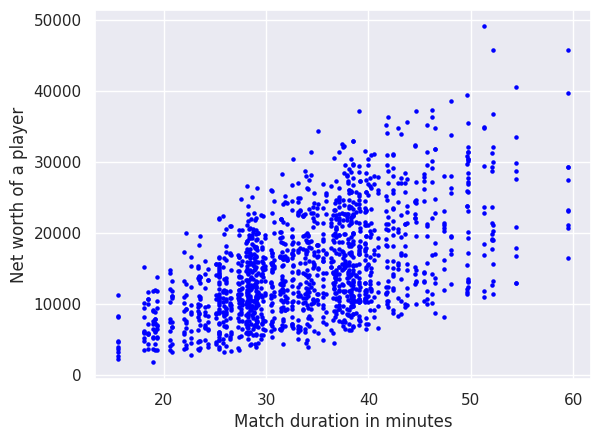

In [26]:
players_subset = players[players.match_start_date_time >= '2024-03-30']
plt.scatter(players_subset.match_duration_minutes,players_subset.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

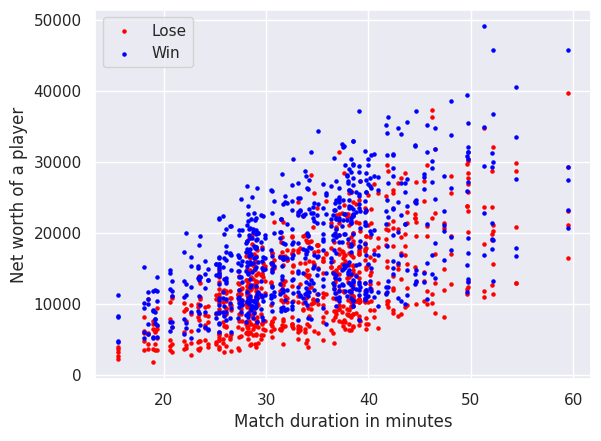

In [27]:
colors = {True: 'blue', False: 'red'}
labels = {True: 'Win', False: 'Lose'}

for status, data in players_subset.groupby('win'):
    plt.scatter(data.match_duration_minutes, data.networth,
               color=colors[status], label=labels[status], s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.legend()

plt.show()

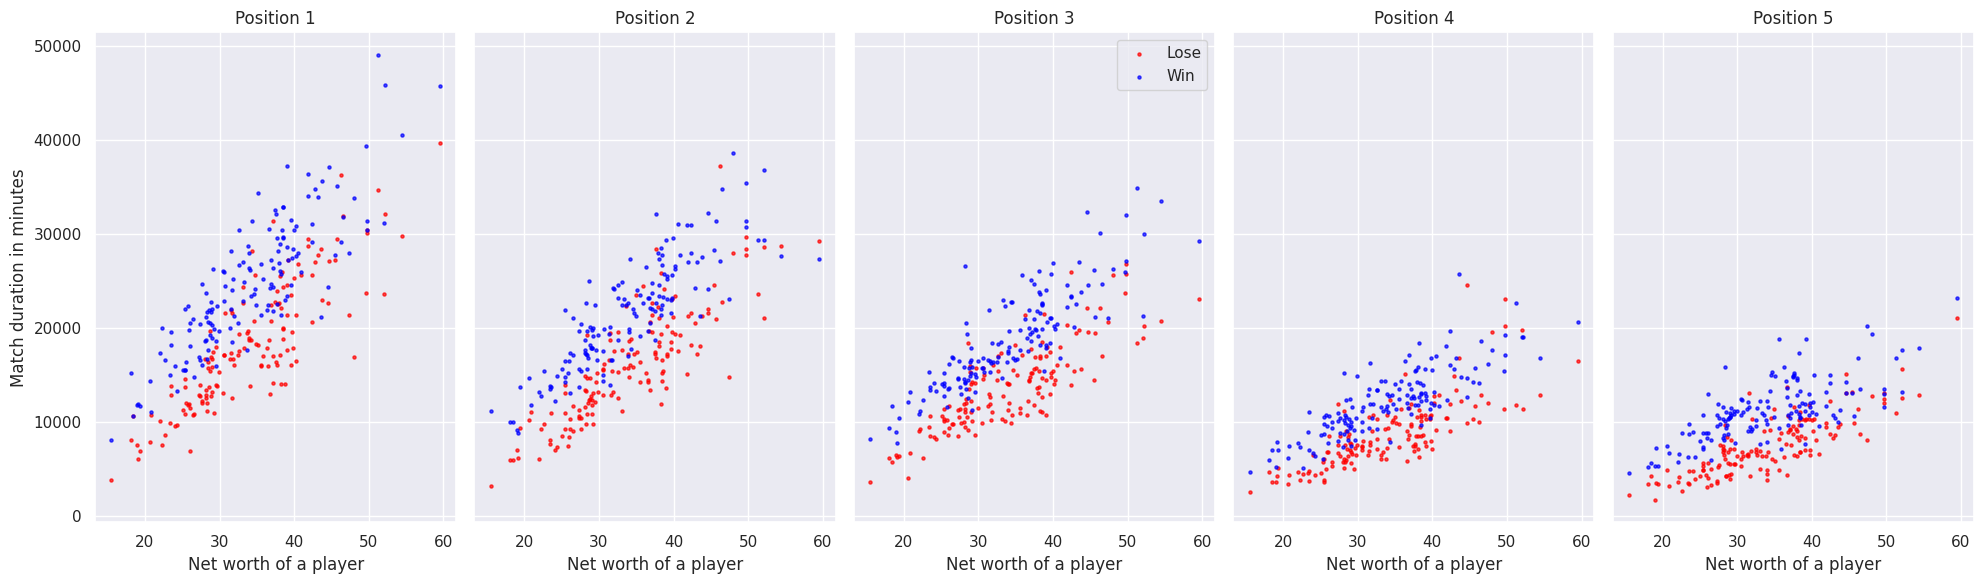

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)  
colors_win_lose = {True: 'blue', False: 'red'}  

for position in range(1, 6):
    ax = axs[position-1]
    for win, data in players_subset[players_subset['position'] == position].groupby('win'):
        ax.scatter(data.match_duration_minutes, data.networth,
                   color=colors_win_lose[win], label=f'{"Win" if win else "Lose"}', s=5, alpha=0.7)
    ax.set_title(f'Position {position}')
    if position == 1:
        ax.set_ylabel('Match duration in minutes')
    ax.set_xlabel('Net worth of a player')
    if position == 3:  
        ax.legend()

plt.tight_layout()
plt.show()

## Association Analysis

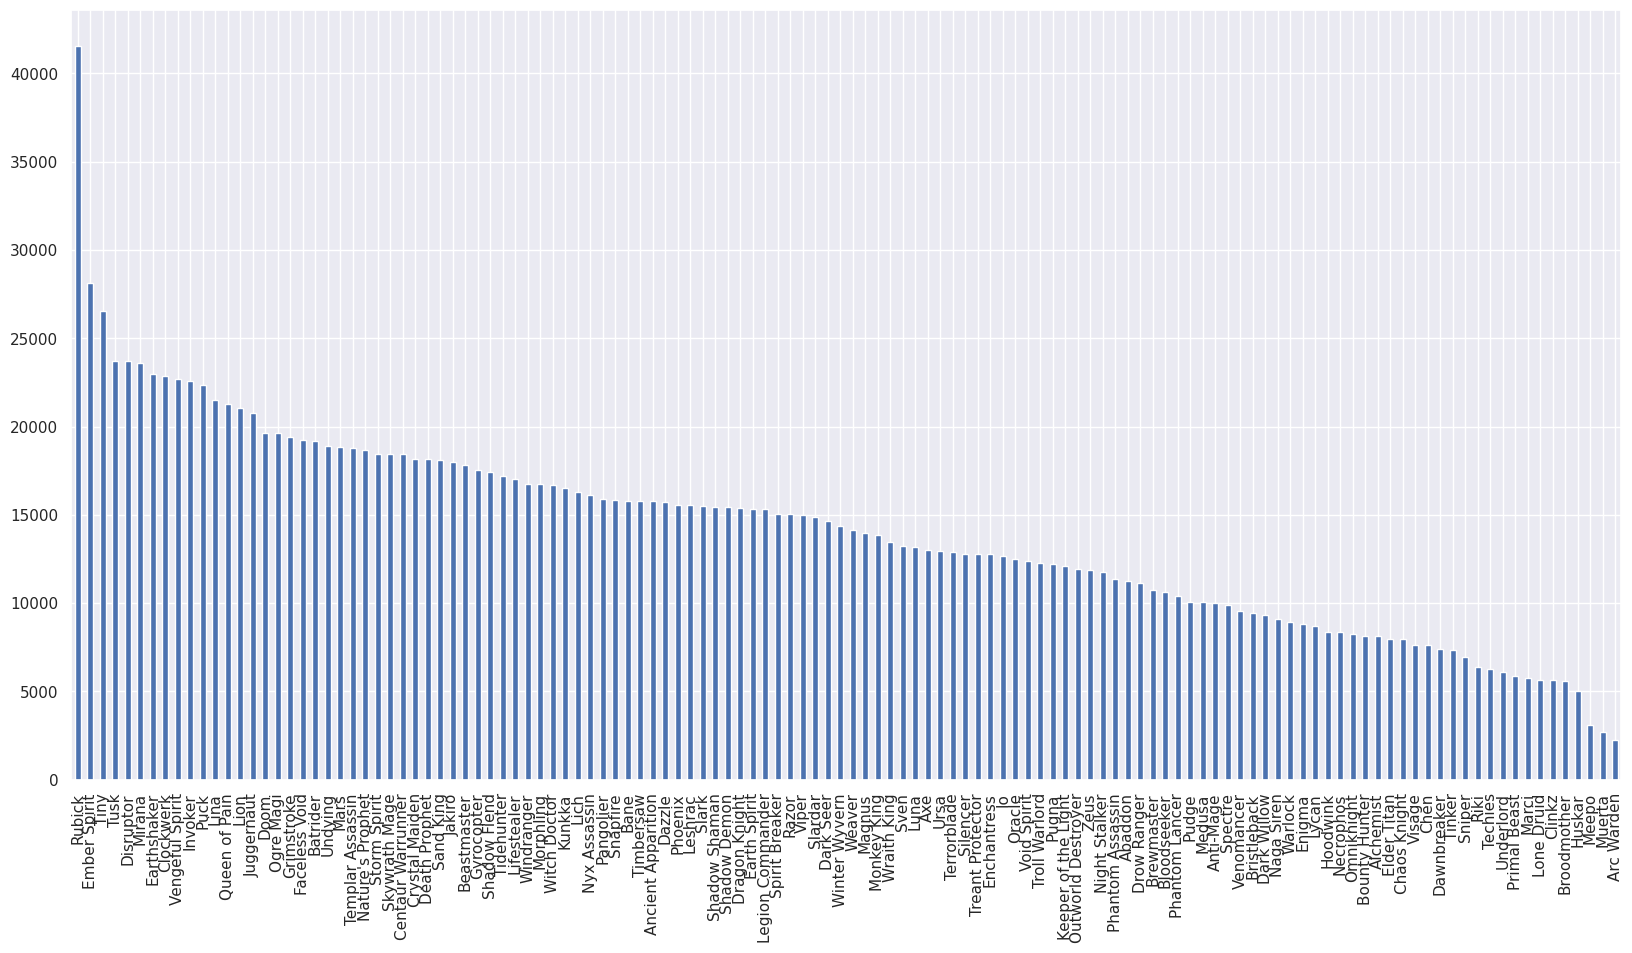

In [29]:
import matplotlib.pyplot as plt

count_1 = matches["radiant_player_1_hero"].value_counts(ascending=False)
count_2 = matches["radiant_player_2_hero"].value_counts(ascending=False)
count_3 = matches["radiant_player_3_hero"].value_counts(ascending=False)
count_4 = matches["radiant_player_4_hero"].value_counts(ascending=False)
count_5 = matches["radiant_player_5_hero"].value_counts(ascending=False)

count_6 = matches["dire_player_1_hero"].value_counts(ascending=False)
count_7 = matches["dire_player_2_hero"].value_counts(ascending=False)
count_8 = matches["dire_player_3_hero"].value_counts(ascending=False)
count_9 = matches["dire_player_4_hero"].value_counts(ascending=False)
count_10 = matches["dire_player_5_hero"].value_counts(ascending=False)

count_df = pd.concat([count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8
                , count_9, count_10], axis=1)
count_df['Total']= count_df.sum(axis=1)
count_df = count_df.sort_values('Total', ascending = False)

plt.figure(figsize=(20,10))
count_df['Total'].plot.bar()
plt.show()

In [30]:
heroes_df = matches[matches.match_start_date_time > LOWER_THRESHOLD_DATE]
heroes_df = heroes_df.dropna()
heroes_arr = heroes_df[["radiant_player_1_hero", "radiant_player_2_hero", "radiant_player_3_hero", 
           "radiant_player_4_hero", "radiant_player_5_hero"]].values.tolist()
heroes_arr.extend(heroes_df[["dire_player_1_hero", "dire_player_2_hero", "dire_player_3_hero", 
                "dire_player_4_hero", "dire_player_5_hero"]].values.tolist())

In [31]:
a = TransactionEncoder()
a_data = a.fit(heroes_arr).transform(heroes_arr)
heroes_df = pd.DataFrame(a_data,columns=a.columns_)
heroes_df

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Arc Warden,Axe,Bane,Batrider,Beastmaster,Bloodseeker,...,Viper,Visage,Void Spirit,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71225,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71226,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
71227,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71228,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [32]:
frequent_itemsets = apriori(heroes_df, min_support = 0.005, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.022140,(Abaddon)
1,0.025032,(Alchemist)
2,0.022420,(Ancient Apparition)
3,0.023445,(Anti-Mage)
4,0.008115,(Arc Warden)
...,...,...
241,0.006079,"(Windranger, Spirit Breaker)"
242,0.005419,"(Vengeful Spirit, Tiny)"
243,0.005279,"(Windranger, Tiny)"
244,0.005672,"(Windranger, Tusk)"


In [33]:
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1.5)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(rules[["antecedents", "consequents", "confidence", "lift"]])

            antecedents          consequents  confidence   lift
0          (Grimstroke)  (Centaur Warrunner)       0.105  1.578
1   (Centaur Warrunner)         (Grimstroke)       0.110  1.578
2            (Snapfire)          (Clockwerk)       0.085  1.605
3           (Clockwerk)           (Snapfire)       0.108  1.605
4      (Crystal Maiden)              (Pudge)       0.087  1.648
5               (Pudge)     (Crystal Maiden)       0.146  1.648
6       (Death Prophet)               (Tiny)       0.166  2.098
7                (Tiny)      (Death Prophet)       0.090  2.098
8       (Death Prophet)               (Tusk)       0.143  1.763
9                (Tusk)      (Death Prophet)       0.075  1.763
10             (Mirana)       (Ember Spirit)       0.132  1.531
11       (Ember Spirit)             (Mirana)       0.088  1.531
12           (Snapfire)      (Faceless Void)       0.075  1.525
13      (Faceless Void)           (Snapfire)       0.103  1.525
14   (Legion Commander)      (Skywrath M

## Clustering

In [34]:
clustering_df = matches[matches.match_start_date_time > LOWER_THRESHOLD_DATE]
clustering_df = clustering_df.dropna()

common_features = [col for col in clustering_df.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]

player_dfs = []

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        player_cols = [col for col in clustering_df.columns if col.startswith(f"{team}_player_{i}_")]
        selected_columns = common_features + player_cols
        temp_df = clustering_df[selected_columns].copy()
        temp_df.columns = [col.replace(f"{team}_player_{i}_", '') if col.startswith(f"{team}_player_{i}_") else col for col in temp_df.columns]
        temp_df['team'] = team
        temp_df['position'] = temp_df.position.apply(lambda s: int(s[-1]) if pd.notna(s) and s != '' else pd.NA)
        temp_df['win'] = temp_df.radiant_win if team == 'radiant' else ~temp_df.radiant_win
        temp_df['win'] = temp_df.win.astype(bool)
        player_dfs.append(temp_df)

players = pd.concat(player_dfs, ignore_index=True)

In [35]:
players.columns

Index(['league', 'league_id', 'league_tier', 'league_start_date_time',
       'league_end_date_time', 'league_region', 'series_id', 'series_type',
       'match_id', 'match_start_date_time', 'match_duration_seconds',
       'first_blood_time_seconds', 'radiant_team_id', 'radiant_team_name',
       'dire_team_id', 'dire_team_name', 'winner_id', 'radiant_kills',
       'dire_kills', 'game_version_id', 'year_month', 'total_kills',
       'match_duration_minutes', 'radiant_win', 'id', 'name', 'hero_id',
       'hero', 'position', 'lane', 'role', 'kills', 'deaths', 'assists',
       'networth', 'team', 'win'],
      dtype='object')

In [36]:
players['kda'] = (players['kills'] + players['assists']) / players['deaths'].replace(0, 1)

grouped = players.groupby('hero')

averages = pd.DataFrame(columns=['hero', 'kda_avg', 'networth_avg'])

for name, group in grouped:
    kda_avg = group['kda'].mean()
    networth_avg = group['networth'].mean()
    averages = pd.concat([averages, pd.DataFrame({'hero': [name], 'kda_avg': [kda_avg], 'networth_avg': [networth_avg]})])


attributes = ['kda_avg', 'networth_avg']
data = averages[attributes]

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 

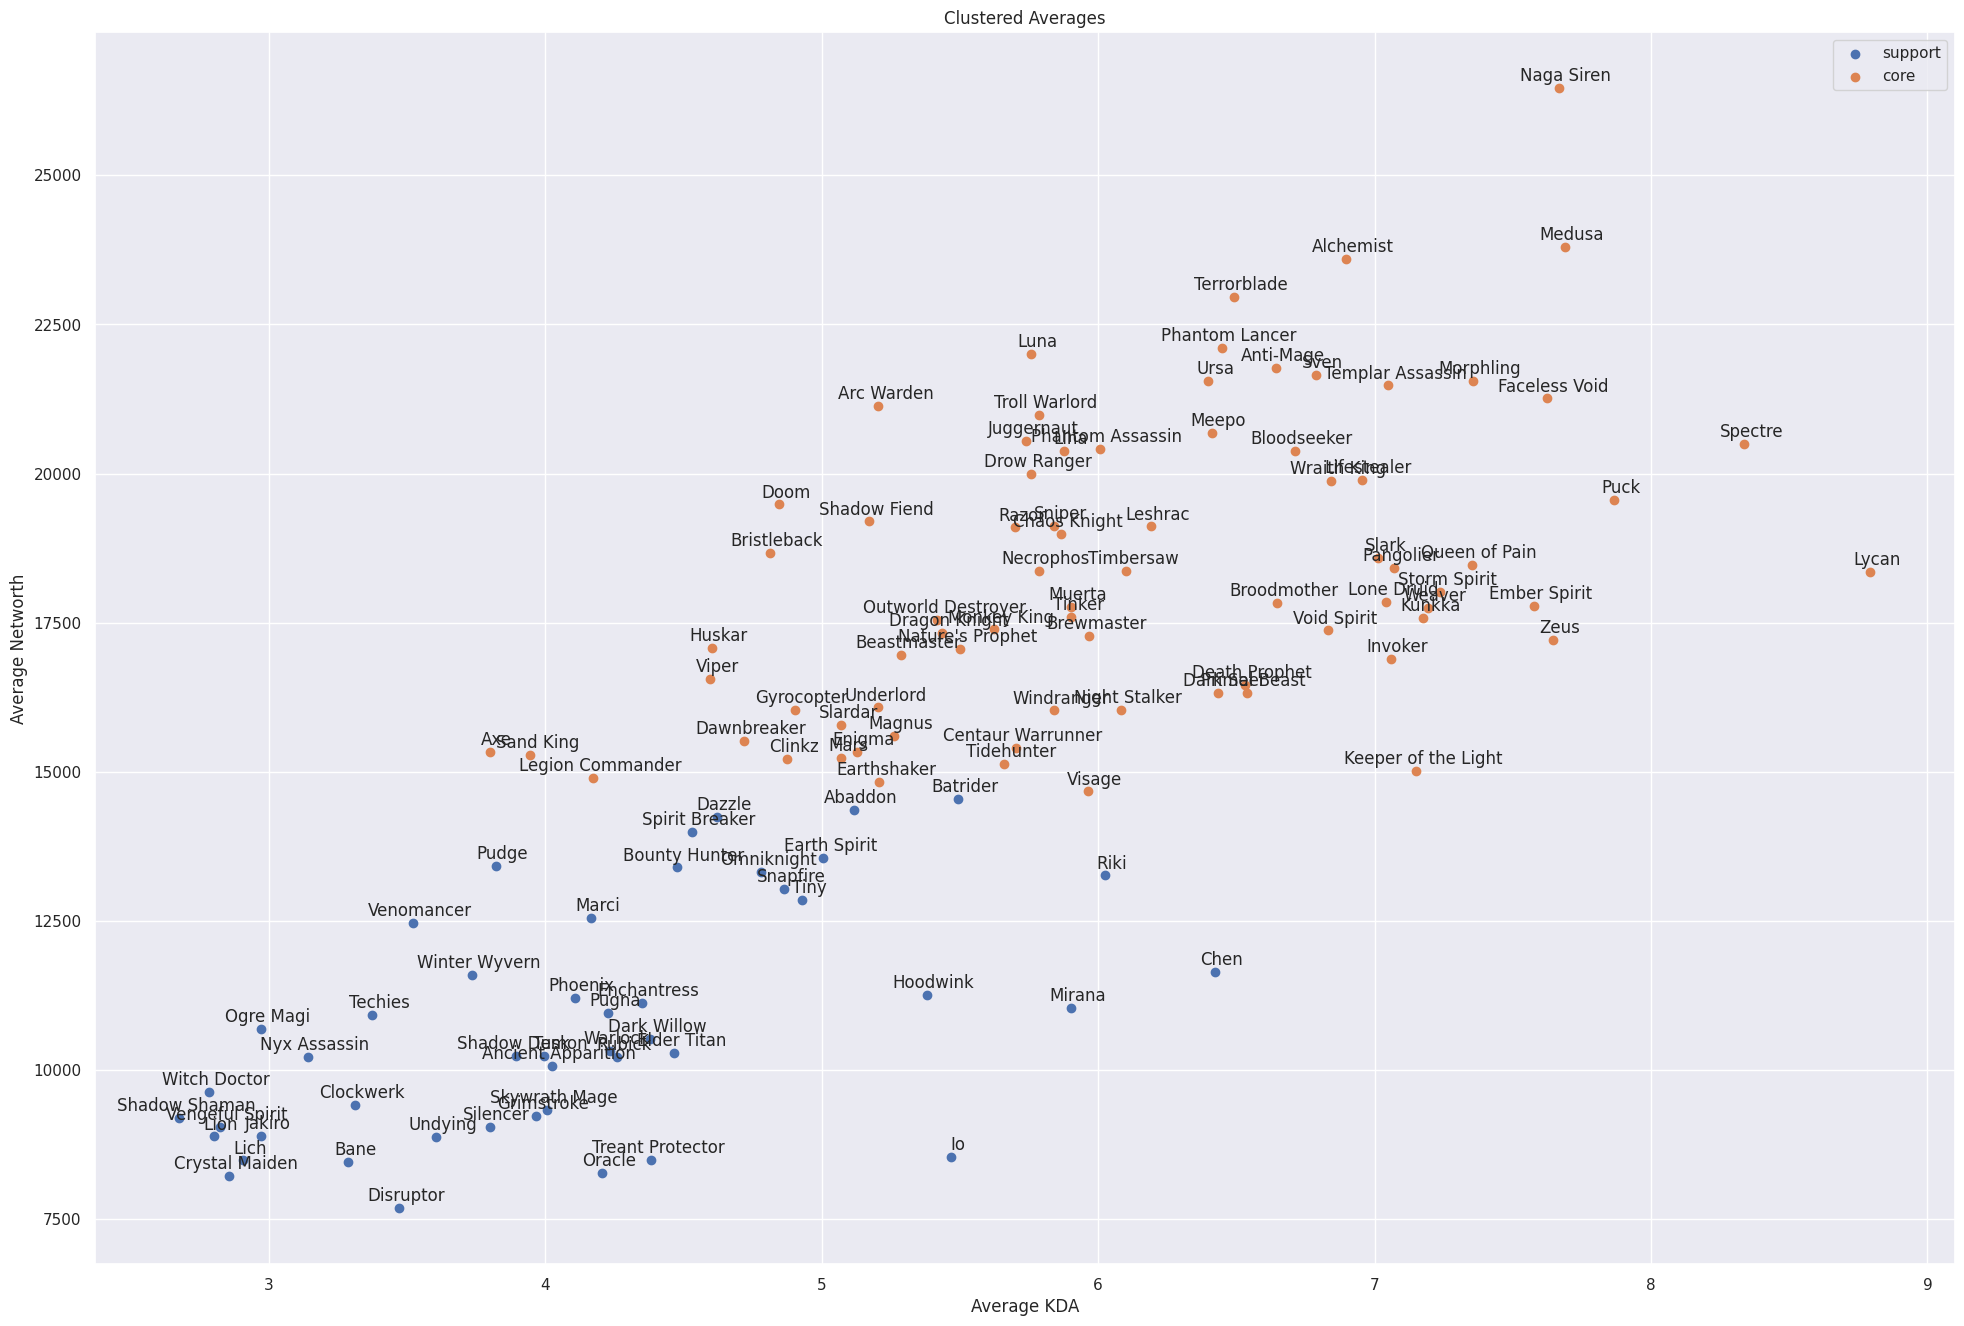

In [37]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

data_normalized = data.fillna(0)

#data_normalized = (data_filled - data_filled.mean()) / data_filled.std()

k = 2

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(data_normalized)

cluster_labels = kmeans.labels_

averages['cluster'] = cluster_labels

plt.figure(figsize=(24, 16))
for cluster in range(k):
    role = ''
    if(cluster == 0):
        role = 'support'
    else:
        role = 'core'
    cluster_data = averages[averages['cluster'] == cluster]
    plt.scatter(cluster_data['kda_avg'], cluster_data['networth_avg'], label=role)

    for _, row in cluster_data.iterrows():
        plt.annotate(row['hero'], (row['kda_avg'], row['networth_avg']), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Average KDA')
plt.ylabel('Average Networth')
plt.title('Clustered Averages')
plt.legend()
plt.show()

## Feature Encoding

In [38]:
get_features_with_most_missing_values(matches)

radiant_player_2_networth    80374
radiant_player_3_networth    80374
dire_player_3_networth       80374
radiant_player_1_networth    80374
radiant_player_4_networth    80374
                             ...  
dire_kills                       0
radiant_player_1_hero_id         0
radiant_player_1_kills           0
radiant_player_1_deaths          0
radiant_win                      0
Length: 134, dtype: int64


In [39]:
matches = matches.dropna()

In [40]:
empty_strs = defaultdict(int)
for column in matches.columns:
    if matches[column].dtype == 'string[pyarrow]' and '' in matches[column].unique():
        empty_strs[column]+=1
    
print(f"Columns that have empty string '' : {empty_strs.keys()}")

Columns that have empty string '' : dict_keys(['radiant_team_name', 'dire_team_name', 'radiant_player_1_name', 'radiant_player_1_position', 'radiant_player_1_lane', 'radiant_player_1_role', 'radiant_player_2_name', 'radiant_player_2_position', 'radiant_player_2_lane', 'radiant_player_2_role', 'radiant_player_3_name', 'radiant_player_3_position', 'radiant_player_3_lane', 'radiant_player_3_role', 'radiant_player_4_name', 'radiant_player_4_position', 'radiant_player_4_lane', 'radiant_player_4_role', 'radiant_player_5_name', 'radiant_player_5_position', 'radiant_player_5_lane', 'radiant_player_5_role', 'dire_player_1_name', 'dire_player_1_position', 'dire_player_1_lane', 'dire_player_1_role', 'dire_player_2_name', 'dire_player_2_position', 'dire_player_2_lane', 'dire_player_2_role', 'dire_player_3_name', 'dire_player_3_position', 'dire_player_3_lane', 'dire_player_3_role', 'dire_player_4_name', 'dire_player_4_position', 'dire_player_4_lane', 'dire_player_4_role', 'dire_player_5_name', 'dir

In [41]:
matches = matches[matches != ''].dropna()

In [42]:
matches = matches[matches.match_start_date_time > LOWER_THRESHOLD_DATE]

### Drop continuous categorical features

In [43]:
columns_to_drop = ['league', 'league_tier', 'league_region', 'series_type', 'radiant_team_name','dire_team_name','game_version_id',
                   'year_month','league_id','league_start_date_time','league_end_date_time','series_id', 'match_id','match_start_date_time','radiant_team_id','dire_team_id',
                  'winner_id','match_duration_seconds','total_kills','first_blood_time_seconds']
player_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['name','id','hero','lane']:
            col_str = f"{team}_player_{i}_{suffix}"
            columns_to_drop.append(col_str)

df = matches.drop(columns=columns_to_drop)

### Feature Transformation

In [44]:
role_mapping = {'CORE':1,'LIGHT_SUPPORT':2, 'HARD_SUPPORT':3}
position_mapping = {'POSITION_1' : 1,'POSITION_2' : 2,'POSITION_3' : 3,'POSITION_4' : 4,'POSITION_5' : 5}
win_mapping = {True : 1, False : 0}

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['role', 'position']:
            col_str = f"{team}_player_{i}_{suffix}"
            if suffix == 'role': 
                df[col_str] = df[col_str].map(role_mapping)
                continue
            df[col_str] = df[col_str].map(position_mapping)
df['radiant_win'] = df['radiant_win'].map(win_mapping)
df


,radiant_kills,dire_kills,radiant_player_1_hero_id,radiant_player_1_position,radiant_player_1_role,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,radiant_player_2_hero_id,...,dire_player_4_networth,dire_player_5_hero_id,dire_player_5_position,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,match_duration_minutes,radiant_win
0,29,39,61,2,1,8,8,5,13202,63,...,14893,57,3,1,10,3,11,16519,29.933333,0
1,27,13,88,5,3,8,4,10,10436,48,...,7018,2,3,1,8,4,4,15967,28.916667,1
2,36,21,48,1,1,13,0,5,26307,135,...,10137,20,5,3,6,9,16,8084,29.15,1
3,21,30,123,4,2,3,9,8,9083,46,...,13517,54,1,1,6,6,12,17717,28.4,0
4,20,30,107,2,1,4,5,6,9305,111,...,7777,42,3,1,5,5,9,13646,26.066667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37394,15,22,63,4,2,6,0,6,9143,100,...,16663,19,2,1,12,1,4,16826,25.566667,0
37395,51,55,35,1,1,10,9,14,29221,83,...,25686,119,4,2,7,12,29,13582,56.866667,0
37396,21,46,14,1,1,6,8,6,12144,16,...,14158,85,3,1,8,5,16,12696,27.116667,0
37397,16,42,70,1,1,4,5,4,14008,14,...,9740,85,5,3,1,6,26,5597,25.883333,0


In [45]:
df = transform_df(df)

TRANSFORMING ...


100%|██████████| 34380/34380 [00:48<00:00, 702.92it/s]


DONE.


## Feature selection
In this section, we consider using 2 methods for feature selection:

* Correlation
* Information Gain



### Train/Test split

In [46]:
X_train, X_test, y_train, y_test, X_cont_train, X_cont_test, y_train, y_test =  split_data(df)

X_train.shape=(51570, 53), X_test.shape=(17190, 53)


### Correlation

In [47]:
df = correlation_test(df, threshold=0.85)

No features will be dropped


### Information gain

In [50]:
mutual_info = get_gain(X_train, y_train)

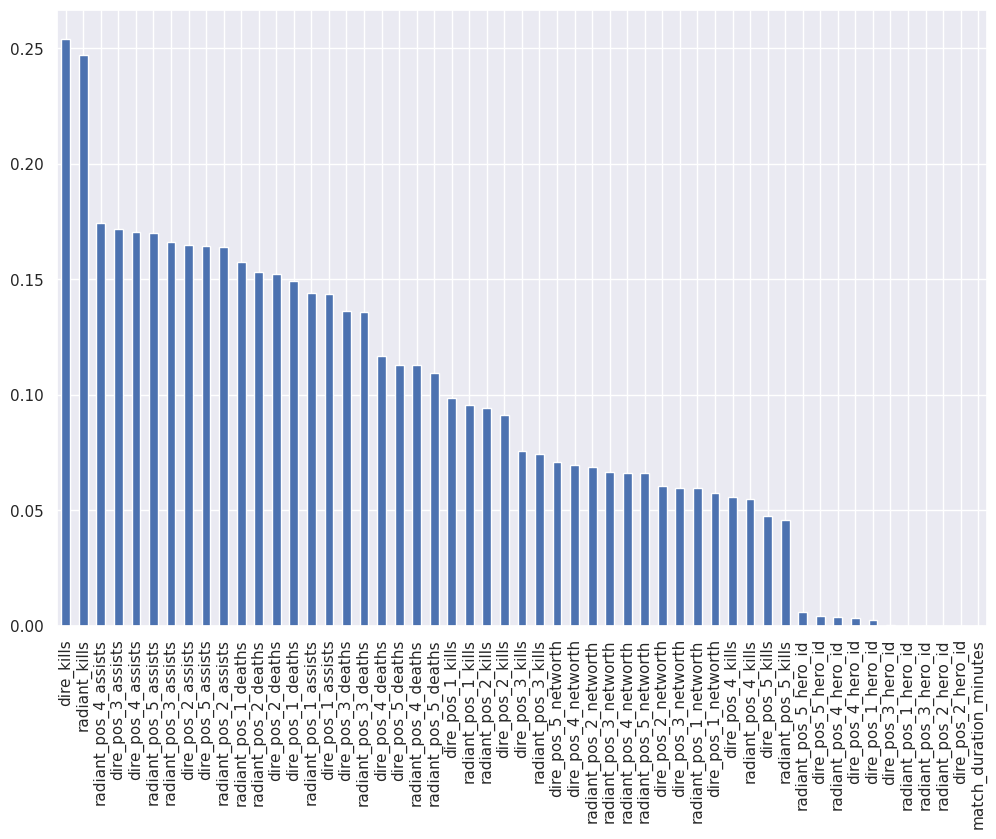

In [51]:
plot_gain_desc(mutual_info)

In [52]:
X_train_selected, X_test_selected, selected_cols = select_k_best(X_train, y_train, X_test, k=52)

## Dimensionality Reduction

Now that we have chosen top K features based on Information Gain, we can further reduce the dimensionality using *`Principal Component Analysis (PCA)`*

#### Standard Scaling

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


#### PCA

In [54]:
X_train_pca, X_test_pca = decompose(X_train_scaled, X_test_scaled, n_components=5)

#### Naive Bayes Classifier vs Linear Discriminant Analysis

In [55]:
models = {}
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
lda_params = {
    'solver': ['lsqr'],
    'shrinkage': [None, 'auto']
}

models['GaussianNB'] = get_best_model('GaussianNB', nb, nb_params)
models['LDA'] = get_best_model('LDA', lda, lda_params)

BEST PARAMS FOR GaussianNB: {'var_smoothing': 1e-09}

0.957 (+/-0.004) for {'var_smoothing': 1e-09}
0.957 (+/-0.004) for {'var_smoothing': 1e-08}
0.957 (+/-0.004) for {'var_smoothing': 1e-07}

BEST PARAMS FOR LDA: {'shrinkage': None, 'solver': 'lsqr'}

0.99 (+/-0.002) for {'shrinkage': None, 'solver': 'lsqr'}
0.99 (+/-0.002) for {'shrinkage': 'auto', 'solver': 'lsqr'}



----------GaussianNB----------
accuracy : 0.9570098894706225
precision : 0.9555504109271906
recall : 0.9587688734030198
f1_score : 0.9571569366340077
roc_auc_score : 0.9918124964466427


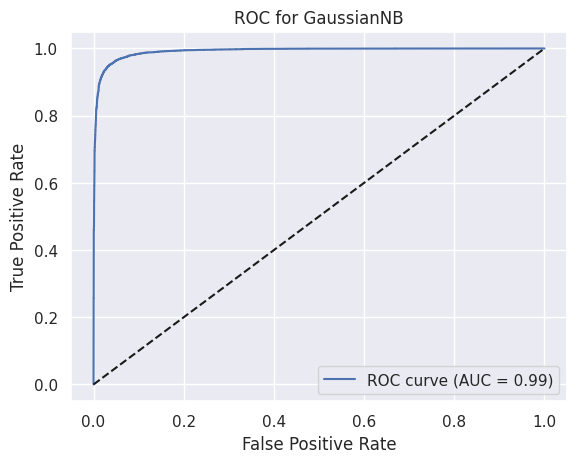

----------LDA----------
accuracy : 0.9899941826643397
precision : 0.9906955105838567
recall : 0.9893147502903601
f1_score : 0.9900046490004649
roc_auc_score : 0.9899953704831754


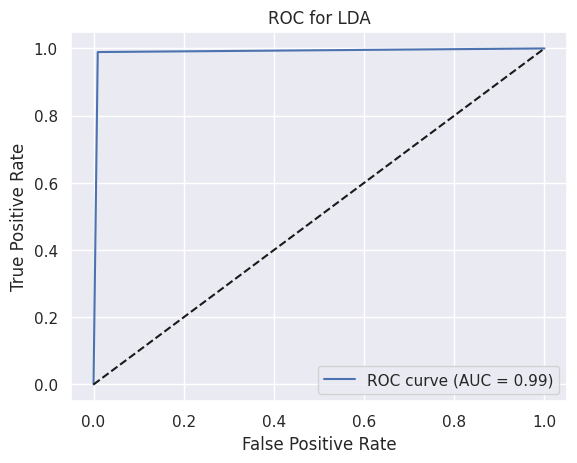

In [56]:
get_scores(models)

## Game outcome prediction at different time frames

In [57]:
maps = np.vstack((matches['radiant_player_1_hero'].T, matches['radiant_player_1_hero_id'].T)).T

id_to_hero = {}
hero_to_id = {}

for pair in maps:
    hero_to_id[pair[0]]=pair[1]
    id_to_hero[pair[1]] = pair[0] 

In [58]:
rad_heroes = ['Io','Riki', 'Bane', 'Tusk','Oracle']
dir_heroes = ['Arc Warden', 'Medusa', 'Naga Siren', 'Anti-Mage', "Nature's Prophet"]

predict_outcome_dummy(rad_heroes, dir_heroes)

Radiant Win : 0.0%
Dire Win : 100.0
--------------------
So, Dire will most likely win


In [59]:
ndf = pd.read_parquet(matches_path, engine='pyarrow')
ndf = ndf.dropna()
ndf = ndf[ndf['match_start_date_time'] > LOWER_THRESHOLD_DATE]

In [60]:
first_df = ndf[ndf['match_duration_seconds'] < 1201]
second_df = ndf[(ndf['match_duration_seconds'] > 1200) & (ndf['match_duration_seconds'] < 1801)]
third_df = ndf[(ndf['match_duration_seconds'] > 1800) & (ndf['match_duration_seconds'] < 2401)]
fourth_df = ndf[(ndf['match_duration_seconds'] > 2400) & (ndf['match_duration_seconds'] < 3001)]
fifth_df = ndf[(ndf['match_duration_seconds'] > 3000) & (ndf['match_duration_seconds'] < 3601)]
sixth_df = ndf[ndf['match_duration_seconds'] > 3600]

In [61]:
cols_list = []
txt1 = "{side}_player_{order}_hero"
txt2 = "{side}_player_{order}_kills"
txt3 = "{side}_player_{order}_deaths"
txt4 = "{side}_player_{order}_assists"
txt5 = "{side}_player_{order}_networth"
txt6 = "{side}_player_{order}_position"

sides = ['radiant', 'dire']
orders = range(1,6)
txt_list = [txt1, txt2, txt3, txt4, txt5, txt6]

for k in range(6):
    for j in range(len(sides)):
        for i in range(len(orders)):
            cols_list.append(txt_list[k].format(side = sides[j], order = orders[i]))

In [62]:
df_array = [first_df, second_df, third_df, fourth_df, fifth_df, sixth_df]

count_df_1 = pd.DataFrame()
count_df_2 = pd.DataFrame()
count_df_3 = pd.DataFrame()
count_df_4 = pd.DataFrame()
count_df_5 = pd.DataFrame()
count_df_6 = pd.DataFrame()

count_df_array = [count_df_1, count_df_2, count_df_3, count_df_4, count_df_5, count_df_6]

for i in range(len(df_array)):
    df_array[i] = df_array[i][cols_list]
    count_1 = df_array[i][["radiant_player_1_hero", "radiant_player_1_position"]].value_counts(ascending=False)
    count_2 = df_array[i][["radiant_player_2_hero", "radiant_player_2_position"]].value_counts(ascending=False)
    count_3 = df_array[i][["radiant_player_3_hero", "radiant_player_3_position"]].value_counts(ascending=False)
    count_4 = df_array[i][["radiant_player_4_hero", "radiant_player_4_position"]].value_counts(ascending=False)
    count_5 = df_array[i][["radiant_player_5_hero", "radiant_player_5_position"]].value_counts(ascending=False)

    count_6 = df_array[i][["dire_player_1_hero", "dire_player_1_position"]].value_counts(ascending=False)
    count_7 = df_array[i][["dire_player_2_hero", "dire_player_2_position"]].value_counts(ascending=False)
    count_8 = df_array[i][["dire_player_3_hero", "dire_player_3_position"]].value_counts(ascending=False)
    count_9 = df_array[i][["dire_player_4_hero", "dire_player_4_position"]].value_counts(ascending=False)
    count_10 = df_array[i][["dire_player_5_hero", "dire_player_5_position"]].value_counts(ascending=False)
    
    count_df_array[i] = pd.concat([count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8
                    , count_9, count_10], axis=1)

    count_df_array[i]['Total']= count_df_array[i].sum(axis=1)
    count_df_array[i] = count_df_array[i].sort_values('Total', ascending = False)
    count_df_array[i]['Total']
    
count_df_array[2]['Total']

Rubick             POSITION_4    3709.0
Crystal Maiden     POSITION_5    2409.0
Ember Spirit       POSITION_2    2338.0
Pangolier          POSITION_2    1801.0
Centaur Warrunner  POSITION_3    1693.0
                                  ...  
Dark Seer          POSITION_5       1.0
Disruptor          POSITION_3       1.0
Puck               POSITION_5       1.0
Lycan              POSITION_4       1.0
Mars               POSITION_5       1.0
Name: Total, Length: 592, dtype: float64

In [63]:
heroes_str_list = []
stats_str_list_unordered = []

for i in range(len(sides)):
    for j in range(len(orders)):
        s1 = txt1.format(side = sides[i], order = orders[j])
        s2 = txt6.format(side = sides[i], order = orders[j])
        heroes_str_list.append([s1, s2])

for k in range(len(orders)):
    for j in range(len(sides)):
        comp_list = []
        for i in range(1, 5):
            comp_list.append(txt_list[i].format(side = sides[j], order = orders[k]))
        stats_str_list_unordered.append(comp_list)

stats_str_list = []

for i in range(2):
    for j in range(5):
        stats_str_list.append(stats_str_list_unordered[i + 2*j])

stats_str_list

[['radiant_player_1_kills',
  'radiant_player_1_deaths',
  'radiant_player_1_assists',
  'radiant_player_1_networth'],
 ['radiant_player_2_kills',
  'radiant_player_2_deaths',
  'radiant_player_2_assists',
  'radiant_player_2_networth'],
 ['radiant_player_3_kills',
  'radiant_player_3_deaths',
  'radiant_player_3_assists',
  'radiant_player_3_networth'],
 ['radiant_player_4_kills',
  'radiant_player_4_deaths',
  'radiant_player_4_assists',
  'radiant_player_4_networth'],
 ['radiant_player_5_kills',
  'radiant_player_5_deaths',
  'radiant_player_5_assists',
  'radiant_player_5_networth'],
 ['dire_player_1_kills',
  'dire_player_1_deaths',
  'dire_player_1_assists',
  'dire_player_1_networth'],
 ['dire_player_2_kills',
  'dire_player_2_deaths',
  'dire_player_2_assists',
  'dire_player_2_networth'],
 ['dire_player_3_kills',
  'dire_player_3_deaths',
  'dire_player_3_assists',
  'dire_player_3_networth'],
 ['dire_player_4_kills',
  'dire_player_4_deaths',
  'dire_player_4_assists',
  'dir

In [64]:
df_list_1 = []
df_list_2 = []
df_list_3 = []
df_list_4 = []
df_list_5 = []
df_list_6 = []

df_list_array = [df_list_1, df_list_2, df_list_3, df_list_4, df_list_5, df_list_6]
for j in range(len(df_array)):
    for i in range(10):
        temp_df = []
        temp_df = df_array[j].groupby(heroes_str_list[i]).sum()
        temp_df = temp_df[stats_str_list[i]]    
        temp_df = temp_df.rename_axis(['hero','pos'])
        df_list_array[j].append(temp_df)

In [65]:
total_kils_df_1 = pd.DataFrame()
total_kils_df_2 = pd.DataFrame()
total_kils_df_3 = pd.DataFrame()
total_kils_df_4 = pd.DataFrame()
total_kils_df_5 = pd.DataFrame()
total_kils_df_6 = pd.DataFrame()

total_kills_df_array = [total_kils_df_1, total_kils_df_2, total_kils_df_3, total_kils_df_4, total_kils_df_5, total_kils_df_6]

for i in range(len(total_kills_df_array)):
    total_kills_df_array[i] = pd.merge(df_list_array[i][0], df_list_array[i][1], left_index=True, right_index=True, how = "outer").fillna(0)
    for j in range(2, len(df_list_array[i])):
        total_kills_df_array[i] = pd.merge(total_kills_df_array[i], df_list_array[i][j], left_index=True, right_index=True, how = "outer").fillna(0)

In [66]:
kills_str_list = []
assists_str_list = []
deaths_str_list = []
networth_str_list = []

for i in range(len(sides)):
    for j in range(len(orders)):
        kills_str_list.append(txt2.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        assists_str_list.append(txt4.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        deaths_str_list.append(txt3.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        networth_str_list.append(txt5.format(side = sides[i], order = orders[j]))

In [67]:
for i in range(len(df_array)):
    total_kills_df_array[i]['total_kills'] =  total_kills_df_array[i][kills_str_list].sum(axis=1)
    total_kills_df_array[i]['total_assists'] = total_kills_df_array[i][assists_str_list].sum(axis=1)
    total_kills_df_array[i]['total_deaths'] = total_kills_df_array[i][deaths_str_list].sum(axis=1)
    total_kills_df_array[i]['total_networth'] = total_kills_df_array[i][networth_str_list].sum(axis=1)
    df_array[i] = total_kills_df_array[i][["total_kills", "total_assists", "total_deaths", "total_networth"]]

In [68]:
pd.options.mode.chained_assignment = None

for i in range(len(df_array)):
    df_array[i]['total_kills'] = df_array[i]['total_kills'].astype(float)
    df_array[i]['total_assists'] = df_array[i]['total_assists'].astype(float)
    df_array[i]['total_deaths'] = df_array[i]['total_deaths'].astype(float)
    df_array[i]['total_networth'] = df_array[i]['total_networth'].astype(float)
    
df_array[2].tail(50)

total_kills  total_assists  total_deaths  \
hero          pos                                                    
Venomancer    POSITION_4        489.0         2240.0        1159.0   
              POSITION_5        961.0         5606.0        2970.0   
Viper         POSITION_1        383.0          484.0         233.0   
              POSITION_2       1271.0         1948.0        1062.0   
              POSITION_3       1619.0         2907.0        1770.0   
              POSITION_4        107.0          183.0         168.0   
              POSITION_5         35.0           94.0          82.0   
Visage        POSITION_1         97.0          135.0          61.0   
              POSITION_2        299.0          378.0         174.0   
              POSITION_3       1636.0         3010.0        1294.0   
              POSITION_4        339.0          948.0         437.0   
              POSITION_5        281.0          768.0         387.0   
Void Spirit   POSITION_1        704.0          751.0         276.0   
              POSITION_2       8032.0         9106.0        4300.0   
              POSITION_3        370.0          485.0         260.0   
              POSITION_4        177.0          290.0         148.0   
              POSITION_5         11.0           36.0          18.0   
Warlock       POSITION_2          7.0           17.0          12.0   
              POSITION_3          8.0           12.0           6.0   
              POSITION_4        148.0          610.0         296.0   
              POSITION_5       1854.0         8448.0        3896.0   
Weaver        POSITION_1       5942.0         5979.0        2561.0   
              POSITION_2        128.0          109.0          69.0   
              POSITION_3        384.0          499.0         230.0   
              POSITION_4       1171.0         2851.0        1336.0   
              POSITION_5        193.0          518.0         321.0   
Windranger    POSITION_1       3106.0         3370.0        1520.0   
              POSITION_2       7181.0         7966.0        3832.0   
              POSITION_3       4128.0         5176.0        2975.0   
              POSITION_4       1509.0         4201.0        2099.0   
              POSITION_5        607.0         1841.0         930.0   
Winter Wyvern POSITION_1         81.0          149.0          84.0   
              POSITION_2        591.0         1089.0         583.0   
              POSITION_3        465.0          913.0         496.0   
              POSITION_4        704.0         2840.0        1609.0   
              POSITION_5        449.0         2388.0        1401.0   
Witch Doctor  POSITION_1         13.0           38.0          19.0   
              POSITION_2        472.0          503.0         254.0   
              POSITION_3        129.0          219.0         164.0   
              POSITION_4       1031.0         1956.0        1571.0   
              POSITION_5       2574.0         5489.0        4289.0   
Wraith King   POSITION_1       3990.0         5137.0        2163.0   
              POSITION_2         18.0           28.0          14.0   
              POSITION_3       1424.0         2995.0        1275.0   
              POSITION_4         10.0           41.0          25.0   
Zeus          POSITION_1        111.0          102.0          48.0   
              POSITION_2      10043.0        13714.0        5135.0   
              POSITION_3        124.0          182.0          90.0   
              POSITION_4       1120.0         2401.0        1043.0   
              POSITION_5        449.0         1023.0         490.0   

                          total_networth  
hero          pos                         
Venomancer    POSITION_4       1482310.0  
              POSITION_5       3563520.0  
Viper         POSITION_1        761727.0  
              POSITION_2       3254452.0  
              POSITION_3       3758565.0  
              POSITION_4        205337.0  
              POSITION_5         60896.0 

In [69]:
for i in range(len(df_array)):
    index_list = df_array[i].index.tolist()
    for j in index_list:
        cnt = count_df_array[i]['Total'].loc[[j]]
        if(cnt.iloc[0] < 10):
            df_array[i] = df_array[i].drop(j)
        else:
            df_array[i].loc[[j], 'total_kills'] = round(df_array[i].loc[[j], 'total_kills'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_assists'] = round(df_array[i].loc[[j], 'total_assists'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_deaths'] = round(df_array[i].loc[[j], 'total_deaths'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_networth'] = round(df_array[i].loc[[j], 'total_networth'] / cnt.iloc[0], 2)

In [70]:
res_df = df_array[3].sort_values(by=['total_networth'])
res_df

,,total_kills,total_assists,total_deaths,total_networth
hero,pos,,,,
Sven,POSITION_5,1.79,19.07,9.36,8622.64
Omniknight,POSITION_5,1.68,16.32,7.41,8736.59
Riki,POSITION_4,2.56,24.03,7.71,9277.90
Bane,POSITION_5,2.77,15.47,10.16,9487.68
Riki,POSITION_5,2.24,22.71,9.05,9649.10
...,...,...,...,...,...
Terrorblade,POSITION_1,8.16,9.72,4.15,31610.18
Anti-Mage,POSITION_1,9.92,9.11,4.36,31817.89
Alchemist,POSITION_1,8.03,13.42,4.66,32236.61


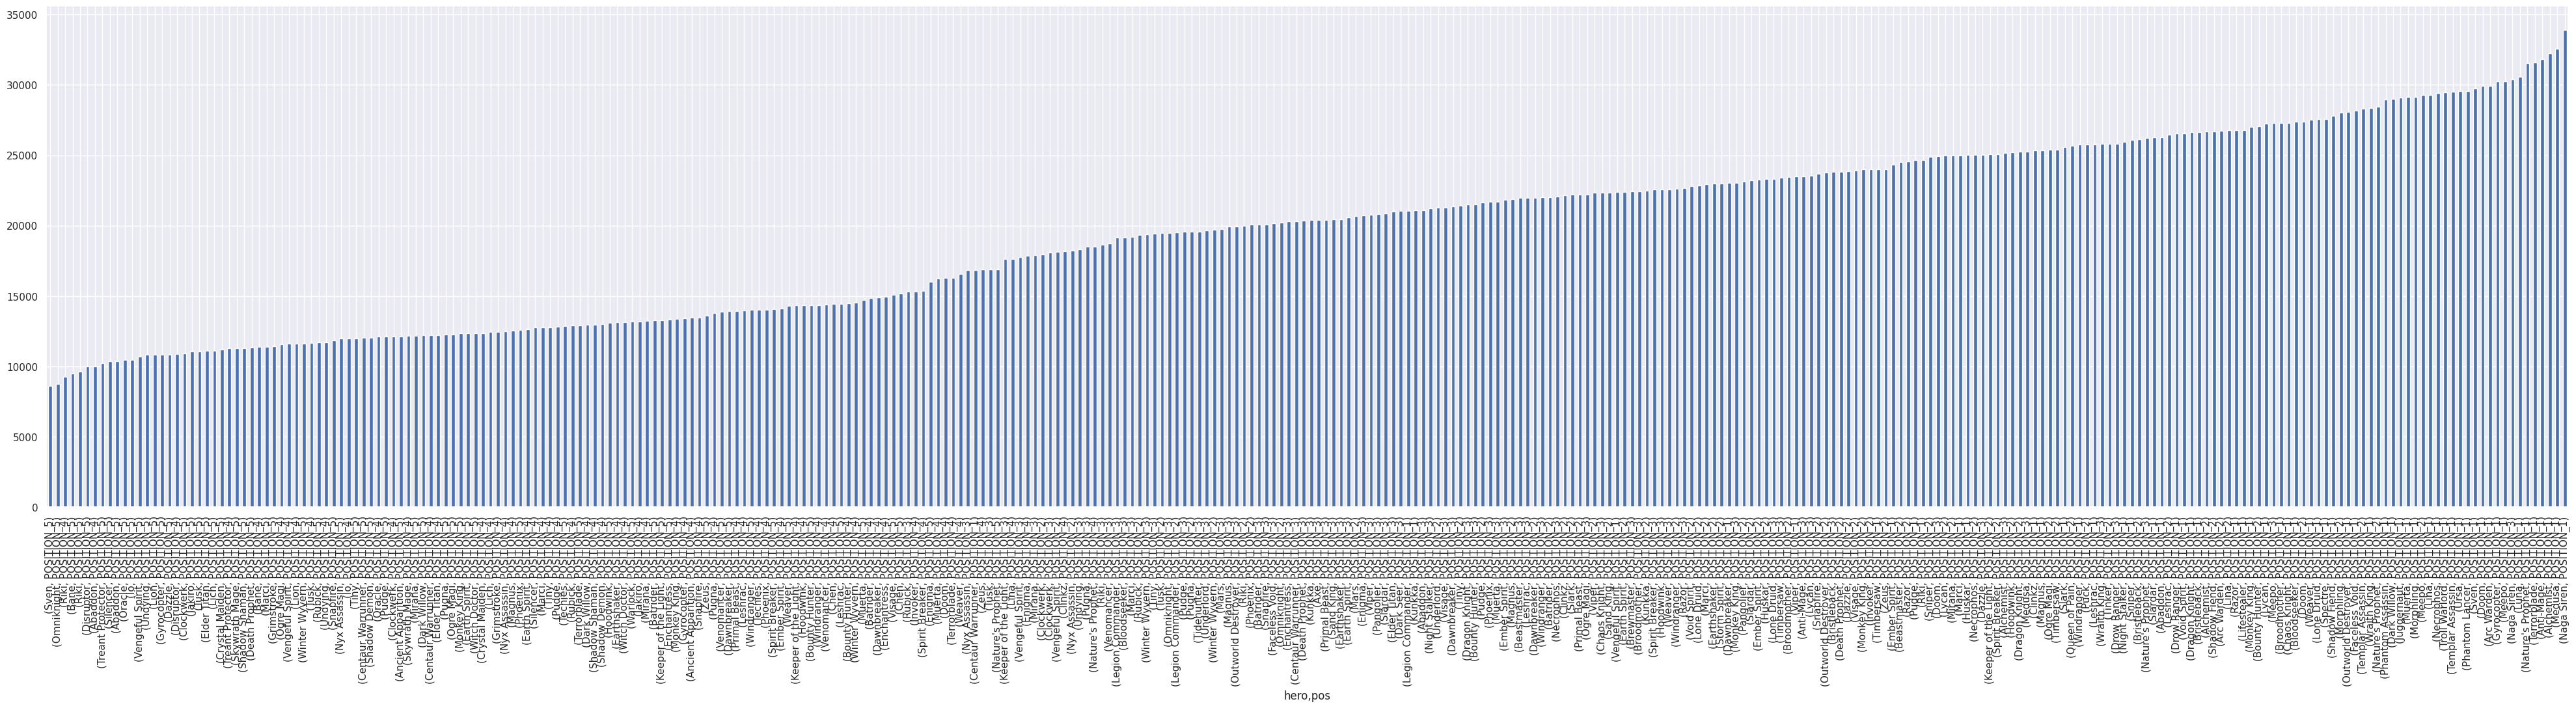

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,10))
res_df['total_networth'].plot.bar()

plt.show()

In [72]:
txt1 = "{side}_pos_{order}_hero_id"
txt2 = "{side}_pos_{order}_kills"
txt3 = "{side}_pos_{order}_assists"
txt4 = "{side}_pos_{order}_deaths"
txt5 = "{side}_pos_{order}_networth"


sides = ['radiant', 'dire']
orders = range(1,6)
txt_list = [txt1, txt2, txt3, txt4, txt5]

In [73]:
duration = [
    [0, 20],
    [20, 30],
    [30, 40],
    [40, 50],
    [50, 60],
    [60, 'infinity']
]

### Outcome prediction of arbitrary data points

In [74]:
rad_heroes_list = [['Luna','Kunkka', 'Tidehunter', 'Enchantress','Pugna'],
                   ['Luna','Invoker', 'Tidehunter', 'Enchantress','Pugna'],
                   ['Luna','Invoker', 'Kunkka', 'Weaver','Pugna'],
                   ['Phantom Assassin','Primal Beast', 'Axe', 'Skywrath Mage','Enchantress'],
                   ['Chaos Knight','Tinker', 'Centaur Warrunner', 'Grimstroke','Ancient Apparition'],
                   ['Weaver','Viper', 'Slardar', 'Batrider','Tusk']
                  ]

dire_heroes_list = [['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"],
                    ['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"],
                    ['Bloodseeker', 'Necrophos', 'Centaur Warrunner', 'Muerta', "Phoenix"],
                    ['Bristleback', 'Pangolier', 'Pudge', 'Grimstroke', "Crystal Maiden"],
                    ['Terrorblade', 'Kunkka', 'Magnus', 'Shadow Demon', "Elder Titan"],
                    ['Pudge', 'Puck', 'Primal Beast', 'Techies', "Vengeful Spirit"]
                   ]

for rad_heroes, dir_heroes in zip(rad_heroes_list, dire_heroes_list):
    predict_outcome_at_different_time(rad_heroes, dir_heroes)
    print('*'*100,end='\n')

For interval 0 to 20 minutes:
Radiant Win : 25.0%
Dire Win : 75.0
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 54.35%
Dire Win : 45.65
So, Radiant will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 52.49%
Dire Win : 47.51
So, Radiant will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 35.39%
Dire Win : 64.61
So, Dire will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 9.81%
Dire Win : 90.19
So, Dire will most likely win
--------------------
For interval 60 to infinity minutes:
Radiant Win : 76.38%
Dire Win : 23.62
So, Radiant will most likely win
--------------------
****************************************************************************************************
For interval 0 to 20 minutes:
Radiant Win : 21.94%
Dire Win : 78.06
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 49.5

### Evaluation of outcome prediction at different times

In [81]:
testset = generate_testcases(df[:200])
evaluate_model(testset)

100%|██████████| 4/4 [00:25<00:00,  6.26s/it]

Accuracy: 0.555
Recall: 0.58
Precision: 0.5523809523809524
F1 Score: 0.5658536585365854
